# Quick start

## Installation

The Python module can be directly installed from [PyPI](https://pypi.org/project/anta-database/) with:

    pip install anta_database


This Python module is designed to query and visualized data in a AntADatabase folder. This folder has to be downloaded, contact me for access.
You can already have a look at this guide to have an idea of the features of this tool.


## Browsing the database

First, initialize the Database class by providing the full path to the AntADatabase:

In [1]:
from anta_database import Database

db = Database('/home/anthe/documents/data/isochrones/AntADatabase/')

Use the query() function to browse the database. 'query()' without argument will return all metadata contained in the database:

In [2]:
db.query()

Metadata from query:

  - author: Franke_2025, Beem_2021, Cavitte_2020, Mulvaney_2023, Wang_2023, Sanderson_2024, Winter_2018

  - age: 4700, 4800, 7200, 10000, 10516, 10700, 11100, 15400, 16800, 25600, 29100, 29300, 30397, 31400, 36300, 37600, 38000, 38100, 39215, 46600, 47110, 48000, 51400, 52200, 62235, 72500, 73100, 73400, 74000, 75160, 75300, 80007, 81900, 82646, 90000, 91000, 93900, 95500, 97400, 97667, 108315, 108600, 122800, 128542, 128800, 135600, 159600, 161000, 162000, 165200, 166112, 169100, 199700, 202334, 219500, 240397, 253400, 262159, 278000, 326168, 326800, 340400, 345462, 367800, 381523, 395802, 400000, 414644, 420000, 483000, 516000, 559000, 610000, 705000

  - var: BedElev, IceThk, SurfElev

  - trace_id: 20231211_02_011, 20231211_02_019, 20231211_01_010, 20022112, 20181226_02_008, IRH_20172048, 19972304, HRB7-HRB8_proc2, SPC_GCX0d_Y83a, IRH_20172027, DoCo_2007_08_07, 20023102, DC_LDC_DIVIDE, 20173002, EPICA_VI_35, 20231211_01_008, RAID2-BH36E_proc2, RSAR_9MI_clippe

The query() function takes as argument:
- author: author(s) of the datasets of interest
- age: age(s) in yrs before present of the layer(s) of interest
- var: variables(s) other than age depth such as 'IceThk', 'SurfElev' or 'BedElev'
- trace_id: ID of a particular trace. This is useful for explicit trace IDs such as 'DC_LDC_DIVIDE'

One can also combine field queries as well as providing lists. Here are a few examples:

In [ ]:
#Examples of queries:
db.query(author='Cavitte_2020') # all data from Cavitte et al. 2020
db.query(age='38100') # all datasets with the 38.1ka isochrone
db.query(var='IceThk') # all datasets with IceThk variable
db.query(trace_id='DC_LDC_DIVIDE') # all layers with the trace ID DC_LDC_DIVIDE
db.query(author=['Franke_2025', 'Winter_2018'], age='38100') # example of multiple criteria

## Visualization

Use the results of the query in the plotting functions:

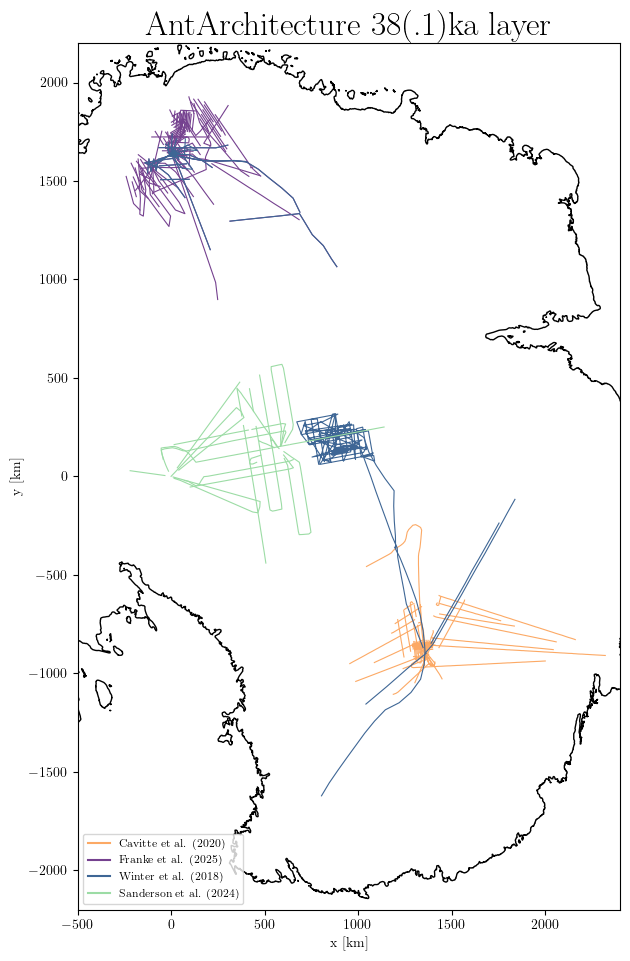

In [ ]:
results = db.query(age=['38100','38000'])
db.plotXY(results,
                downscale_factor=1000, # downscale the datasets n times, which makes no visual difference but it is much lighter
                title='AntArchitecture 38(.1)ka layer',
                xlim=(-500, 2400), ylim=(-2200, 2200), # set the plot extent in km
                scale_factor=0.7, # adjust the size of the plot
                latex=True, # use latex compilers for plotting if you have them installed on your system
                # save='AntA_38ka.pdf', # Uncomment to save the figure, otherwise it we visualize with pyplot
                )

Current implemented plotting functions are:
- plotXY(): plot locations of the data, with different colors for the different datasets (example above) 
- plotXYDepth(): scatter plot with a colormap displaying the values of the data (example below) 

In Jupyter Notebook, use '%matplotlib qt' or '%matplotlib widget' depending on your IDE, to switch to the matplotlib widget that allows you to zoom in etc.
Use '%matplotlib inline' (default) to plot the figure in the notebook 

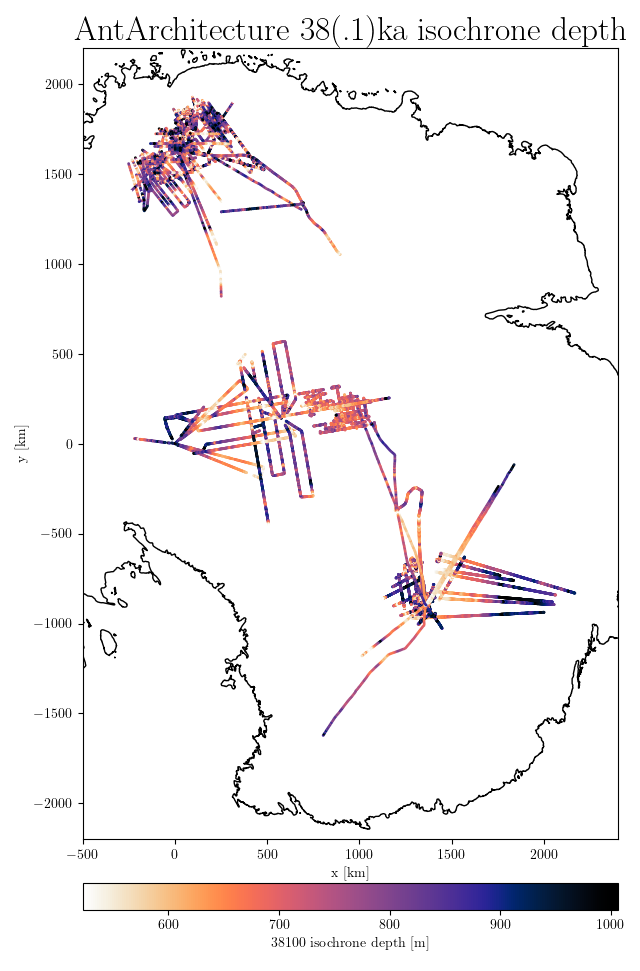

In [ ]:
# %matplotlib widget
%matplotlib inline
results = db.query(age=['38100','38000'])
db.plotXYDepth(results, title='AntArchitecture 38(.1)ka isochrone depth',
                downscale_factor=100,
                xlim=(-500, 2400),
                ylim=(-2200, 2200),
                scale_factor=0.7,
                latex=True,
                # save='AntA_38ka_depth.png'
                )


## Generate data from the database

Note: This part could be developed further in the future if there is the need. But for now, I am designing a separate Python module for constraining my ice sheet model of use, which is tailored to this database and other parallel processing libraries.

The data_generator() function reads the query and 'yield' the dataframes for later use.
Here is a quick example of how this can be used for computing the mean layer depth:

In [ ]:
results = db.query(age=['38100'])
lazy_dfs = db.data_generator()

import numpy as np
mean_depth_trs = []
min_depth = float('inf')
max_depth = float('-inf')
for df, md in lazy_dfs:
    depth_values = df[md['age']]
    mean_depth_trs.append(np.mean(depth_values))
    min_depth = min(min_depth, min(depth_values))
    max_depth = max(max_depth, max(depth_values))


mean_depth = np.mean(mean_depth_trs)
std_dev = np.std(mean_depth_trs, ddof=1)
print(f"The mean depth of the 38ka isochrone across East Antarctica is {round(mean_depth, 2)} m ranging from {round(min_depth, 2)} m to {round(max_depth, 2)} m.")

The mean depth of the 38ka isochrone across East Antarctica is 1127.89 m ranging from 313.34 m to 2213.46 m.


In the for loop, 'df' is an individual dataframe from the database, corresponding to a single layer of a single trace from a single dataset. The 'md' stores the unique metadata from the current 'df'. One can then associate the metadata with the current df, for example:

In [ ]:
results = db.query(author='Cavitte_2020', trace_id='DC_LDC_DIVIDE')
lazy_dfs = db.data_generator(results)

import matplotlib.pyplot as plt
# from matplotlib import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True) # Do you use latex?

for df, md in lazy_dfs:
    if md['age'] is not None:
        plt.plot(df.distance/1000, df[md['age']], label=md['age'])
    if md['var'] == 'IceThk':
        plt.plot(df.distance/1000, df['IceThk'], linewidth=2, color='k', label='Bedrock')

plt.legend(ncol=2)
plt.xlabel('Distance (km)')
plt.ylabel('Depth (m)')
plt.ylim(4000, 0)
plt.title('Isochronal structure along DC_LDC_DIVIDE transect')
plt.show()

### Downscale the data

The downscale_factor argument in the data_generator reduces the size of the generated data by n times. This is useful when dealing with large data where the downscaling has a neglectable influence on the results.
Another solution, probably more straightforward, is the downsample_distance option, which allows to provide a distance in meters by which the data should be average along the transects:

In [ ]:
import matplotlib.pyplot as plt

results = db.query(author='Cavitte_2020', age='278000', trace_id='DC_LDC_DIVIDE')
original = db.data_generator(results)
downscale_10 = db.data_generator(results, downscale_factor=100)
downsampled_by_distance = db.data_generator(results, downsample_distance=5000)

list = [original, downscale_10, downsampled_by_distance]
labels = ['original', 'downscale 100', 'downsample 5km']

for i, lazy_dfs in enumerate(list):
    for df, md in lazy_dfs:
        plt.plot(df.distance, df['278000'],label=labels[i], linestyle='--')

plt.ylim(3000, 0)
plt.xlabel('Distance along DC_LDC_DIVIDE (km)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('Different downscaling methods for Cavitte 2020 278ka along DC_LDC_DIVIDE')
plt.show()